# Navigation

---

In this notebook, we train DQN agent to navigate the large square world and collect yellow bananas.
A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana.  The goal of our agent is to collect as many yellow bananas as possible while avoiding blue bananas.

You will need to download the environment that matches your operating system and extract the contents under PROJECT_ROOT/**env** folder:
- Linux: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip)
    - Mac OSX: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana.app.zip)
    - Windows (32-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86.zip)
    - Windows (64-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Windows_x86_64.zip)

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os
import sys
import pickle
from unityagents import UnityEnvironment
import numpy as np

from time import time
from collections import deque

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../src/')

from agents import DQNAgent


%load_ext autoreload
%autoreload 2

In [2]:
# Load the environment
env = UnityEnvironment(file_name="../env/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
def get_env_info(env):
    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    
    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents in the environment
    print('Number of agents:', len(env_info.agents))

    # number of actions
    action_size = brain.vector_action_space_size
    print('Number of actions:', action_size)

    # examine the state space 
    state = env_info.vector_observations[0]
    print('States look like:', state)
    state_size = len(state)
    print('States have length:', state_size)
    
    return brain_name, state_size, action_size

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# Grab state and action size
brain_name, state_size, action_size = get_env_info(env)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
start = time()
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
ctr = 0
while True:
    ctr += 1
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}, took: {} seconds".format(score, (time() - start)))

Score: 0.0, took: 29.763253688812256 seconds


# Training

Next, we train a DQN agent with different parameters to find out the one that performs the best.

In [6]:
# Helper functions to train and plot

# Train
def train_dqn(env, agent, num_episodes=2000, eps=1.0, eps_min=0.01, eps_decay=0.995, exp_info=''):
    scores = []
    scores_window = deque(maxlen=100)
    best_score = -np.inf
    for i in range(num_episodes):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        while True:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)                    
            score += reward
            state = next_state
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps * eps_decay, eps_min)
        
        if i % 100 == 0:
            print('\rEpisode: {}/{}, current avg score: {:.2f}, best avg score: {:.2f}'.
                  format(i, num_episodes, np.mean(scores_window), best_score), end='')
            sys.stdout.flush()
            
        # Store the best scoring model    
        if np.mean(scores_window) > best_score:
            best_score = np.mean(scores_window)
            agent.save('../saved_models/dqn_banana_e{}.pth'.format(exp_info))
            
    return scores, best_score    

# Plot network loss and scores
def plot(losses, scores):
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    axs[0].plot(np.arange(len(losses)), losses)
    rolling_mean = pd.Series(losses).rolling(100).mean()
    axs[0].plot(rolling_mean)
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Update step #')
    axs[0].set_title('Loss vs Weights update step')
    
    axs[1].plot(np.arange(len(scores)), scores)
    axs[1].set_ylabel('Score')
    axs[1].set_xlabel('Episode #')
    axs[1].set_title('Score per episode')
    plt.show()    
    
# Helper function to store experiment details    
def record_experiment(filename, record):
    dirname = 'experiments'
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    
    with open('{}/{}'.format(dirname, filename), 'wb') as f:
        pickle.dump(record, f)    

## Experiment 1

Decay epsilon by 0.999

Episode: 1900/2000, current avg score: 12.70, best avg score: 12.74

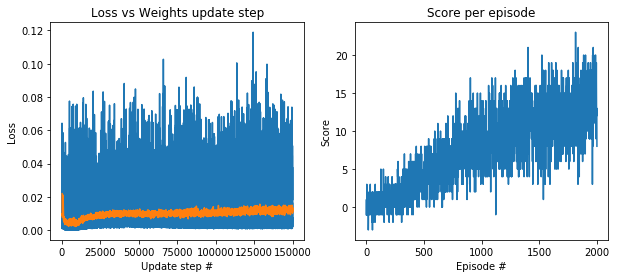

In [7]:
# DQN agent hyper parameters
opts = {
    "LR": 1e-4,
    "GAMMA": 0.90
}

# Initialize the agent
dqn_agent = DQNAgent(state_size, action_size, seed=0, opts=opts)

# Training hyperparameters
eps_decay=0.999
num_episodes=2000

# Train agent
start = time()
scores, best_avg = train_dqn(env, dqn_agent, num_episodes=num_episodes, eps_decay=eps_decay, exp_info='1')
end = time()

# Plot score and losses
losses = dqn_agent.history['loss']
plot(losses, scores)

# Record experiment output, metedata for future analysis
record = {
    "time": end - start,
    "opts": opts,
    "eps_decay": eps_decay,
    "scores": scores,
    "losses": losses
}

record_experiment('lr-{}_decay-{}_gamma-{}_episodes-{}_bestscore-{}'.format(
    opts['LR'], eps_decay, opts['GAMMA'], num_episodes, best_avg
), record)

In [10]:
# The agent does take quite a bit of time to train. 
print('Training time: {:.2f} mins'.format(record['time']/60))

Training time: 29.80 mins


--- 

## Experiment 2

Keep epsilon decay same, try changing the learning rate to update the weights more slowly

Episode: 1900/2000, current avg score: 9.31, best avg score: 9.74

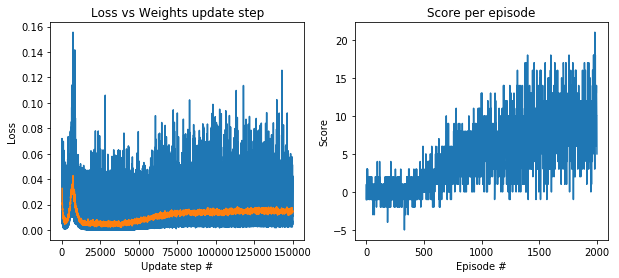

In [7]:
opts = {
    "LR": 1e-5,
    "GAMMA": 0.90
}


# Initialize the agent
dqn_agent = DQNAgent(state_size, action_size, seed=0, opts=opts)

# Hyper parameters
eps_decay=0.999
num_episodes=2000

# Train agent
start = time()
scores, best_avg = train_dqn(env, dqn_agent, num_episodes=num_episodes, eps_decay=eps_decay, exp_info='2')
end = time()

# Plot score and losses
losses = dqn_agent.history['loss']
plot(losses, scores)

# Record experiment output, metedata for future analysis
record = {
    "time": end - start,
    "opts": opts,
    "eps_decay": eps_decay,
    "scores": scores,
    "losses": losses
}

record_experiment('lr-{}_decay-{}_gamma-{}_episodes-{}_bestscore-{}'.format(
    opts['LR'], eps_decay, opts['GAMMA'], num_episodes, best_avg
), record)

The agent didn't do as well as experiment 1. This means we can restore the learning rate and experiment with epsilon decay

---

## Experiment 3

Restore learning rate and play with epsilon decay to find the best possible explore-exploit level

Episode: 1900/2000, current avg score: 15.92, best avg score: 17.18

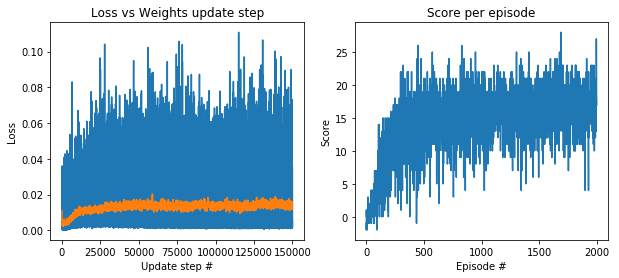

In [8]:
opts = {
    "LR": 1e-4,
    "GAMMA": 0.90
}

# Initialize the agent
dqn_agent = DQNAgent(state_size, action_size, seed=0, opts=opts)

# Hyper parameters
eps_decay=0.99
num_episodes=2000

# Train agent
start = time()
scores, best_avg = train_dqn(env, dqn_agent, num_episodes=num_episodes, eps_decay=eps_decay, exp_info='3')
end = time()

# Plot score and losses
losses = dqn_agent.history['loss']
plot(losses, scores)

# Record experiment output, metedata for future analysis
record = {
    "time": end - start,
    "opts": opts,
    "eps_decay": eps_decay,
    "scores": scores,
    "losses": losses
}

record_experiment('lr-{}_decay-{}_gamma-{}_episodes-{}_bestscore-{}'.format(
    opts['LR'], eps_decay, opts['GAMMA'], num_episodes, best_avg
), record)

This is our best performing agent yet. Let's explore the epsilon decay rates attempted so far

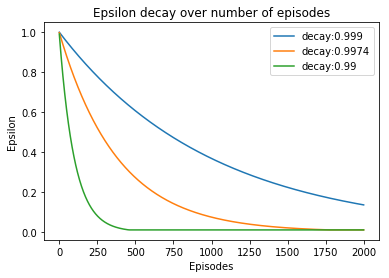

In [20]:
def decay_eps(eps=1.0, eps_min=0.01, decay=0.995):
    epss = []
    for i in range(2000):
        eps = max(eps * decay, eps_min)
        epss.append(eps)
    return epss

decays = [0.999, 0.9974, 0.99]
ds = [decay_eps(decay=d) for d in decays]

for d, decay in zip(ds, decays):
    plt.plot(np.arange(2000), d, label='decay:{}'.format(decay))
    
plt.legend(loc='best')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon decay over number of episodes')
plt.show()

The agent that quickly decays the espilon seems to perform better. Next, we will try to find a better decay rate

---
## Experiment 4

We try with epsilon decay of 0.9974 which is between experiment 1 (0.999) and experiment 3 (0.99)

Episode: 1900/2000, current avg score: 15.61, best avg score: 16.42

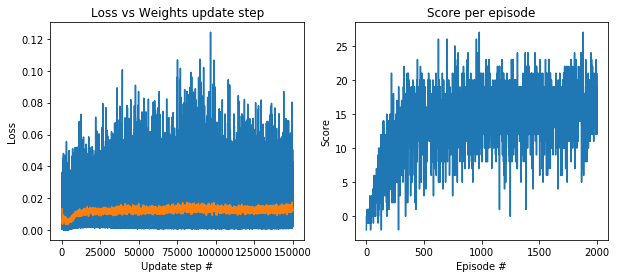

In [22]:
opts = {
    "LR": 1e-4,
    "GAMMA": 0.90
}

# Initialize the agent
dqn_agent = DQNAgent(state_size, action_size, seed=0, opts=opts)

# Hyper parameters
eps_decay=0.99
num_episodes=2000

# Train agent
start = time()
scores, best_avg = train_dqn(
    env, dqn_agent, num_episodes=num_episodes, eps_decay=eps_decay, exp_info='4'
)
end = time()

# Plot score and losses
losses = dqn_agent.history['loss']
plot(losses, scores)

# Record experiment output, metedata for future analysis
record = {
    "time": end - start,
    "opts": opts,
    "eps_decay": eps_decay,
    "scores": scores,
    "losses": losses
}

record_experiment('lr-{}_decay-{}_gamma-{}_episodes-{}_bestscore-{}'.format(
    opts['LR'], eps_decay, opts['GAMMA'], num_episodes, best_avg
), record)

# Experiment 5

Update GAMMA from 0.90 to 0.95

Episode: 1900/2000, current avg score: 16.25, best avg score: 16.73

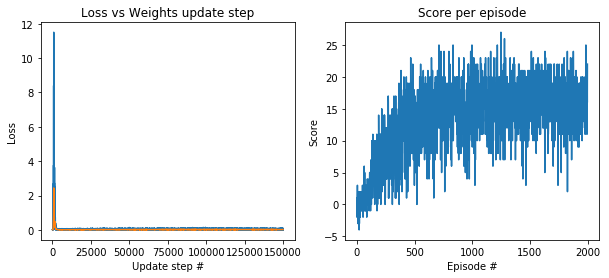

In [23]:
opts = {
    "LR": 1e-4,
    "GAMMA": 0.95
}

# Initialize the agent
dqn_agent = DQNAgent(state_size, action_size, seed=0, opts=opts)

# Hyper parameters
eps_decay=0.99
num_episodes=2000

# Train agent
start = time()
scores, best_avg = train_dqn(
    env, dqn_agent, num_episodes=num_episodes, eps_decay=eps_decay, exp_info='5'
)
end = time()

# Plot score and losses
losses = dqn_agent.history['loss']
plot(losses, scores)

# Record experiment output, metedata for future analysis
record = {
    "time": end - start,
    "opts": opts,
    "eps_decay": eps_decay,
    "scores": scores,
    "losses": losses
}

record_experiment('lr-{}_decay-{}_gamma-{}_episodes-{}_bestscore-{}'.format(
    opts['LR'], eps_decay, opts['GAMMA'], num_episodes, best_avg
), record)

# Experiment 6

Use same epsilon decay rate as Experiment 3 but train longer (3000 episodes)

Episode: 2900/3000, current avg score: 16.57, best avg score: 17.44

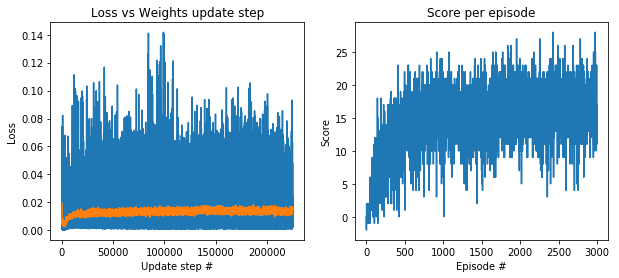

In [25]:
opts = {
    "LR": 1e-4,
    "GAMMA": 0.90
}

# Initialize the agent
dqn_agent = DQNAgent(state_size, action_size, seed=0, opts=opts)

# Hyper parameters
eps_decay=0.99
num_episodes=3000

# Train agent
start = time()
scores, best_avg = train_dqn(
    env, dqn_agent, num_episodes=num_episodes, eps_decay=eps_decay, exp_info='6'
)
end = time()

# Plot score and losses
losses = dqn_agent.history['loss']
plot(losses, scores)

# Record experiment output, metedata for future analysis
record = {
    "time": end - start,
    "opts": opts,
    "eps_decay": eps_decay,
    "scores": scores,
    "losses": losses
}

record_experiment('lr-{}_decay-{}_gamma-{}_episodes-{}_bestscore-{}'.format(
    opts['LR'], eps_decay, opts['GAMMA'], num_episodes, best_avg
), record)

In [26]:
# Close env session
env.close()